In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import re

import sys
sys.path.append('../src')
from SLmodels import *


In [2]:
# Data directory
data_dir = '../data/'

# Find all chern_BR files for L=20, 40, 50
L_values = [20, 40, 50]

def load_chern_data(L):
    """Load Chern number data for a given system size L."""
    # Find the chern_BR file
    pattern = os.path.join(data_dir, f'2dHaldane_L{L}_*_H_chern_BR.dat')
    chern_files = glob.glob(pattern)
    
    if not chern_files:
        print(f"No chern_BR file found for L={L}")
        return None, None
    
    chern_file = chern_files[0]
    print(f"Loading: {os.path.basename(chern_file)}")
    
    # Find corresponding parameters file
    base = chern_file.replace('_H_chern_BR.dat', '')
    param_file = base + '_parameters.txt'
    
    # Load parameters
    params = {}
    with open(param_file, 'r') as f:
        for line in f:
            if '=' in line and not line.startswith('Created'):
                key, value = line.split('=')
                params[key.strip()] = value.strip()
    
    disorder_resolution = int(params['disorder_resolution'])
    num_realizations = int(params['num_disorder_realisations'])
    disorder_start = float(params['disorder_start'])
    disorder_end = float(params['disorder_end'])
    
    # Load chern data - shape is (disorder_resolution, num_realizations)
    shape = (disorder_resolution, num_realizations, L, L)
    chern_data = np.memmap(chern_file, dtype='float64', mode='r', shape=shape)
    
    disorder_values = np.linspace(disorder_start, disorder_end, disorder_resolution)
    
    return disorder_values, np.array(chern_data)

def load_spectral_localizer_data(L):
    """Load Spectral Localizer data for a given system size L."""
    pattern = os.path.join(data_dir, f'2dHaldane_L{L}_*_spectral_localiser_eigval.dat')
    sl_files = glob.glob(pattern)
    
    if not sl_files:
        print(f"No spectral_localizer file found for L={L}")
        return None, None
    
    sl_file = sl_files[0]
    print(f"Loading: {os.path.basename(sl_file)}")
    
    # Find corresponding parameters file
    base = sl_file.replace('_spectral_localiser_eigval.dat', '')
    param_file = base + '_parameters.txt'
    
    # Load parameters
    params = {}
    with open(param_file, 'r') as f:
        for line in f:
            if '=' in line and not line.startswith('Created'):
                key, value = line.split('=')
                params[key.strip()] = value.strip()
    
    disorder_resolution = int(params['disorder_resolution'])
    num_realizations = int(params['num_disorder_realisations'])
    disorder_start = float(params['disorder_start'])
    disorder_end = float(params['disorder_end'])
    
    # Load spectral localizer data - shape is (disorder_resolution, num_realizations, 4*L*L)
    # Note: SL matrix is 4*L*L (block matrix with 2x2 blocks of 2*L*L each)
    shape = (disorder_resolution, num_realizations, 4*L*L)
    sl_data = np.memmap(sl_file, dtype='float64', mode='r', shape=shape)
    
    disorder_values = np.linspace(disorder_start, disorder_end, disorder_resolution)
    
    return disorder_values, np.array(sl_data)

In [3]:
# Load data for each L
data = {}
data_sl = {}
for L in L_values:
    disorder_vals, chern_vals = load_chern_data(L)
    disorder_vals_sl, sl_vals = load_spectral_localizer_data(L)
    if disorder_vals is not None:
        data[L] = {'disorder': disorder_vals, 'chern': chern_vals}
    if disorder_vals_sl is not None:
        data_sl[L] = {'disorder': disorder_vals_sl, 'sl': sl_vals}


Loading: 2dHaldane_L20_w_1.5_disorder0.0-5.0_numEigs600_realizations75_2025-12-16-162504_H_chern_BR.dat
Loading: 2dHaldane_L20_w_1.5_disorder0.0-5.0_numEigs600_realizations75_2025-12-16-162504_spectral_localiser_eigval.dat
Loading: 2dHaldane_L40_w_1.5_disorder0.0-5.0_numEigs600_realizations75_2025-12-16-162504_H_chern_BR.dat
Loading: 2dHaldane_L40_w_1.5_disorder0.0-5.0_numEigs600_realizations75_2025-12-16-162504_spectral_localiser_eigval.dat
Loading: 2dHaldane_L50_w_1.5_disorder0.0-5.0_numEigs600_realizations75_2025-12-16-162637_H_chern_BR.dat
Loading: 2dHaldane_L50_w_1.5_disorder0.0-5.0_numEigs600_realizations75_2025-12-16-162637_spectral_localiser_eigval.dat


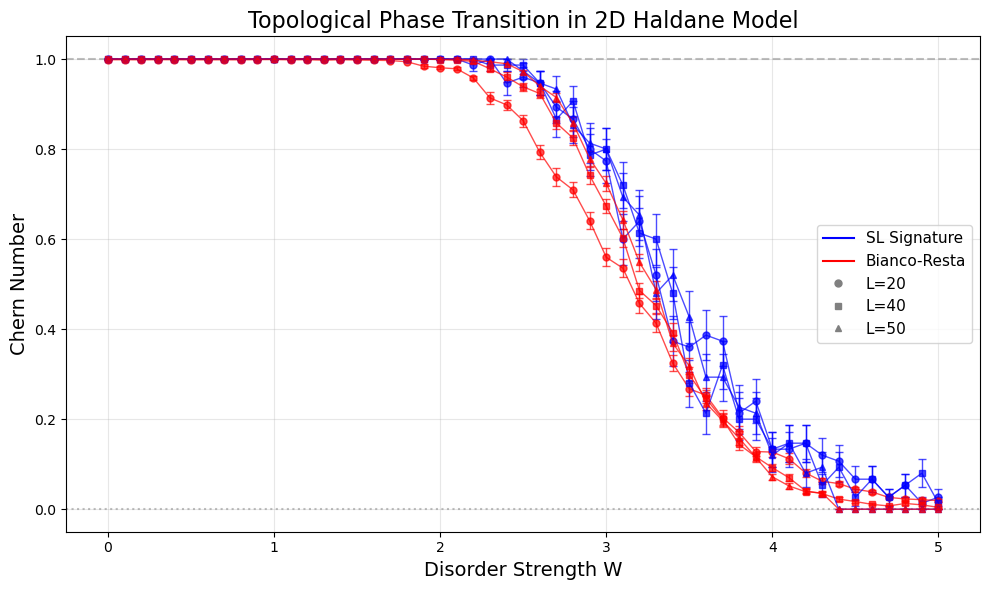

In [4]:
# Plot Chern number vs disorder
fig, ax = plt.subplots(figsize=(10, 6))

# Markers for different system sizes
markers = {20: 'o', 40: 's', 50: '^'}
# Colors for different methods
color_sl = 'blue'
color_br = 'red'

for L in L_values:
    if L not in data:
        continue

    disorder_vals = data[L]['disorder']
    # Shape is confirmed to be: (disorder_res, num_realizations, L, L)
    chern_vals = data[L]['chern'] 

    sl_vals = data_sl[L]['sl'] if L in data_sl else None
    # calculate signature of spectral localizer, averaged over realisations
    sl_signatures = np.sum(np.sign(sl_vals), axis=-1)
    sl_signatures = sl_signatures / 2

    sl_mean = np.mean(sl_signatures, axis=1)
    sl_std = np.std(sl_signatures, axis=1) / np.sqrt(sl_signatures.shape[1])

    ax.errorbar(disorder_vals, sl_mean, yerr=sl_std,
        label=f'L={L} SL Sig' if L == L_values[0] else f'L={L}',
        color=color_sl, marker=markers[L],
        capsize=3, markersize=5, linewidth=1, alpha=0.7)

    # --- Bianco-Resta Chern marker ---
    
    # 1. Define the "Bulk" (Centre of the model)
    # The local Chern marker is only quantised in the bulk, away from open boundaries.
    # We slice the central region (e.g., the middle half) to avoid edge effects.
    start = L // 4
    end = 3 * L // 4
    
    # Slice spatial dimensions (axes 2 and 3)
    chern_bulk = -chern_vals[:, :, start:end, start:end]
    
    # 2. Average spatially to get the Chern number per realisation
    # This collapses the (L/2, L/2) grid into a single scalar per realisation.
    chern_per_realisation = np.mean(chern_bulk, axis=(2, 3))
    
    # 3. Compute mean and standard error across realisations (axis 1)
    chern_mean = np.mean(chern_per_realisation, axis=1)
    chern_std = np.std(chern_per_realisation, axis=1) / np.sqrt(chern_per_realisation.shape[1])

    ax.errorbar(disorder_vals, chern_mean, yerr=chern_std,
                label=f'L={L} BR' if L == L_values[0] else f'L={L}',
                color=color_br, marker=markers[L],
                capsize=3, markersize=5, linewidth=1, alpha=0.7)

ax.axhline(y=1, color='gray', linestyle='--', alpha=0.5, label='C=1 (topological)')
ax.axhline(y=0, color='gray', linestyle=':', alpha=0.5, label='C=0 (trivial)')

ax.set_xlabel('Disorder Strength W', fontsize=14)
ax.set_ylabel('Chern Number', fontsize=14)
ax.set_title('Topological Phase Transition in 2D Haldane Model', fontsize=16)

# Custom legend: separate entries for methods and sizes
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color=color_sl, marker='', linestyle='-', label='SL Signature'),
    Line2D([0], [0], color=color_br, marker='', linestyle='-', label='Bianco-Resta'),
    Line2D([0], [0], color='gray', marker='o', linestyle='', markersize=5, label='L=20'),
    Line2D([0], [0], color='gray', marker='s', linestyle='', markersize=5, label='L=40'),
    Line2D([0], [0], color='gray', marker='^', linestyle='', markersize=5, label='L=50'),
]
ax.legend(handles=legend_elements, fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig('../figures/2dHaldane_chern_vs_disorder.png', dpi=300)
plt.show()

Calculating SL signature for disorder=0.0
  SL signature: 1.0
Calculating SL signature for disorder=0.1
  SL signature: 1.0
Calculating SL signature for disorder=0.2
  SL signature: 1.0
Calculating SL signature for disorder=0.30000000000000004
  SL signature: 1.0
Calculating SL signature for disorder=0.4
  SL signature: 1.0
Calculating SL signature for disorder=0.5
  SL signature: 1.0
Calculating SL signature for disorder=0.6000000000000001
  SL signature: 1.0
Calculating SL signature for disorder=0.7000000000000001
  SL signature: 1.0
Calculating SL signature for disorder=0.8
  SL signature: 1.0
Calculating SL signature for disorder=0.9
  SL signature: 1.0
Calculating SL signature for disorder=1.0
  SL signature: 1.0
Calculating SL signature for disorder=1.1
  SL signature: 1.0
Calculating SL signature for disorder=1.2000000000000002
  SL signature: 1.0
Calculating SL signature for disorder=1.3
  SL signature: 0.0
Calculating SL signature for disorder=1.4000000000000001
  SL signature

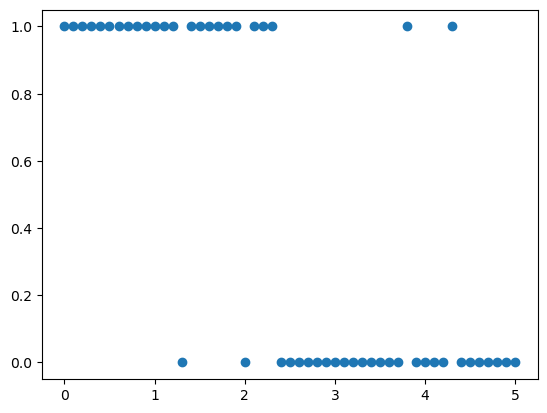

In [5]:
data = []
for disorder in disorder_vals:
    print(f"Calculating SL signature for disorder={disorder}")
    model = TwoDimensionalHaldane(L=20,disorder = disorder, rho=10, kappa=1.0)
    model.find_eigval(model.H,sparse=False)
    model.find_eigval(model.spectral_localiser, sparse=False)

    sl = np.sum(np.sign(model.spectral_localiser_eigval)) / 2
    print(f"  SL signature: {sl}")
    data.append((disorder, sl))

fignew, axnew = plt.subplots()

data = np.array(data)
axnew.plot(data[:,0], data[:,1], marker='o', linestyle='None')
